Baseline with Bert  

I will eventually use dense retreival based models. This is simply a baseline. 

This BERT model is used for processing the abstract information from patent documents. 

In [1]:
import torch 
import torch.nn as nn 
import torch.functional as f 
from torch.optim import AdamW 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler 
from sklearn.model_selection import train_test_split 
import time 
import datetime 
import re 
import math 
import sklearn 
import os
import json 
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup

# Inspect Sample Data

In [2]:
files = os.listdir('sample_data2')
print("number of sample files = {}".format(len(files)))

number of sample files = 12508


In [3]:
with open('sample_data2/'+files[0]) as f: 
    data = json.load(f) 
    print(data.keys())

dict_keys(['patent1id', 'patent2id', 'fullpatent1id', 'fullpatent2id', 'patent1abstract', 'patent2abstract', 'patent1claims', 'patent2claims'])


In [4]:
for file in files: 
    if file == 'labels.json': 
        with open('sample_data2/'+file) as f: 
            labels = json.load(f)           

There are a few problematic json files. For now let's only use samples that we can parse. 

In [5]:
train_abstracts = [] 
train_labels = [] 
problematic = 0 
for idx, file in enumerate(files): 
    filename = 'sample_data2/' + file
    if '.json' not in filename or 'labels' in filename: 
        continue 
    try: 
        with open(filename) as f:  
            data = json.load(f) 
            train_abstracts.append(data) 
            train_labels.append(labels[file])
    except Exception as e: 
        problematic += 1 

In [6]:
print("Number of valid json files = {}".format(len(train_abstracts))) 
print("Number of problematic json files = {}".format(problematic))

Number of valid json files = 11617
Number of problematic json files = 889


Due to not using some json files, we have slightly more positive samples than negatives. 

In [7]:
len(train_labels)

11617

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

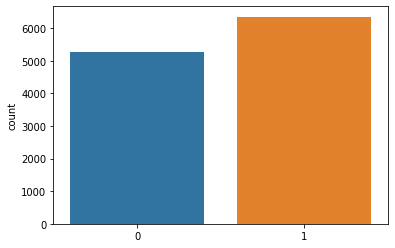

In [8]:
sns.countplot(train_labels) 

In [9]:
ones, zeros = 0, 0 
for num in train_labels:  
    ones += (num==1) 
    zeros += (num==0) 
    
print("ones = {}%".format(ones / len(train_labels)*100)) 
print("zeros = {}%".format(zeros / len(train_labels) * 100)) 

ones = 54.69570457088749%
zeros = 45.30429542911251%


Of the features we have, we are going to use the patent1abstract, patent2abstract and patent1claims and patent2claims. 

We will build separate models for each pairs. 

In [10]:
train_abstracts[0].keys() 

dict_keys(['patent1id', 'patent2id', 'fullpatent1id', 'fullpatent2id', 'patent1abstract', 'patent2abstract', 'patent1claims', 'patent2claims'])

# Preprocess Data

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 

def BERT_Tokenizer(text, MAX_LEN=512): 
    encoded_dict = tokenizer.encode_plus(
        text = text,  
        add_special_tokens = True, 
        pad_to_max_length = False, 
        return_attention_mask = True 
    )
    input_id = encoded_dict['input_ids'] 
    attention_mask = encoded_dict['attention_mask'] 
    
    # get the first 512 tokens
    text_len = len(input_id)
    if len(input_id) > MAX_LEN: 
        input_id = input_id[:MAX_LEN] 
        attention_mask = attention_mask[:MAX_LEN] 
    else: 
        input_id = input_id + [0]*(MAX_LEN - len(input_id)) 
        attention_mask = attention_mask + [0]*(MAX_LEN - len(attention_mask)) 
    
    return input_id, attention_mask, text_len 


In [12]:
# store tokenzied abstract and claims 
abstract1_input_ids, abstract2_input_ids = [], [] 
abstract1_attention_masks, abstract2_attention_masks = [], [] 
abstract1_lengths, abstract2_lengths = [], [] 
labels = []  

for i in tqdm(range(len(train_abstracts)), position=0, leave=True): 
    a1 = train_abstracts[i]['patent1abstract'] 
    a2 = train_abstracts[i]['patent2abstract'] 
               
    a1_input_id, a1_attention_mask, a1_length = BERT_Tokenizer(a1)
    abstract1_input_ids.append(a1_input_id) 
    abstract1_attention_masks.append(a1_attention_mask)
    abstract1_lengths.append(a1_length)   
    
    a2_input_id, a2_attention_mask, a2_length = BERT_Tokenizer(a2) 
    abstract2_input_ids.append(a2_input_id)
    abstract2_attention_masks.append(a2_attention_mask) 
    abstract2_lengths.append(a2_length) 
     
    labels.append(train_labels[i])

100%|██████████| 11617/11617 [01:20<00:00, 144.55it/s]


In [13]:
def token_stats(arr):
    print("mean tokens = {}".format(np.mean(arr))) 
    print("min tokens = {}".format(np.min(arr))) 
    print("max tokens = {}".format(np.max(arr))) 
    print("number of data with more than 512 tokens = {}".format(np.sum(i > 512 for i in arr))) 
    print("percentage of data with more than 512 tokens = {:.2f}%".format(np.sum(i > 512 for i in arr) * 100 / len(arr)))
    print()

In [14]:
token_stats(abstract1_lengths) 

token_stats(abstract2_lengths) 


mean tokens = 134.10966686752172
min tokens = 14
max tokens = 445
number of data with more than 512 tokens = 0
percentage of data with more than 512 tokens = 0.00%

mean tokens = 151.96479297581132
min tokens = 9
max tokens = 600
number of data with more than 512 tokens = 5
percentage of data with more than 512 tokens = 0.04%



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [15]:
abstract1_input_ids = torch.tensor(abstract1_input_ids, dtype=int)
abstract1_attention_masks = torch.tensor(abstract1_attention_masks, dtype=int) 

abstract2_input_ids = torch.tensor(abstract2_input_ids, dtype=int)
abstract2_attention_masks = torch.tensor(abstract2_attention_masks, dtype=int) 

labels = torch.tensor(labels, dtype=float)
labels = torch.reshape(labels, (-1,1))

abstract1_input_ids.shape, abstract1_attention_masks.shape, abstract2_input_ids.shape, abstract2_attention_masks.shape, labels.shape

(torch.Size([11617, 512]),
 torch.Size([11617, 512]),
 torch.Size([11617, 512]),
 torch.Size([11617, 512]),
 torch.Size([11617, 1]))

# Create DataLoader

In [16]:
### obtain train set ### 
train_abstract1_input_ids, other_abstract1_input_ids, train_abstract1_attention_masks, other_abstract1_attention_masks = train_test_split(abstract1_input_ids, 
                                                                                                                                          abstract1_attention_masks, 
                                                                                                                                          random_state = 888, 
                                                                                                                                          test_size = 0.2, 
                                                                                                                                          stratify = labels) 

train_abstract2_input_ids, other_abstract2_input_ids, train_abstract2_attention_masks, other_abstract2_attention_masks = train_test_split(abstract2_input_ids,
                                                                                                                                          abstract2_attention_masks, 
                                                                                                                                          random_state = 888, 
                                                                                                                                          test_size = 0.2, 
                                                                                                                                          stratify = labels)



_, _, train_labels, other_labels = train_test_split(abstract1_input_ids, 
                                                    labels, 
                                                    random_state = 888, 
                                                    test_size = 0.2,
                                                    stratify = labels)

### obtain validation and test set ### 
val_abstract1_input_ids, test_abstract1_input_ids, val_abstract1_attention_masks, test_abstract1_attention_masks = train_test_split(other_abstract1_input_ids, 
                                                                                                                                    other_abstract1_attention_masks, 
                                                                                                                                    random_state = 999, 
                                                                                                                                    test_size = 0.5, 
                                                                                                                                    stratify = other_labels)  

val_abstract2_input_ids, test_abstract2_input_ids, val_abstract2_attention_masks, test_abstract2_attention_masks = train_test_split(other_abstract2_input_ids, 
                                                                                                                                    other_abstract2_attention_masks, 
                                                                                                                                    random_state = 999, 
                                                                                                                                    test_size = 0.5, 
                                                                                                                                    stratify = other_labels)

_, _, val_labels, test_labels = train_test_split(other_abstract1_input_ids, 
                                                 other_labels, 
                                                 random_state = 999, 
                                                 test_size = 0.5, 
                                                 stratify = other_labels)

print("===Train dataset size===") 
print(train_abstract1_input_ids.shape) 
print(train_abstract1_attention_masks.shape)
print(train_abstract2_input_ids.shape) 
print(train_abstract2_attention_masks.shape) 
print(train_labels.shape) 
print() 
print("===Validation dataset size===")
print(val_abstract1_input_ids.shape) 
print(val_abstract1_attention_masks.shape) 
print(val_abstract2_input_ids.shape) 
print(val_abstract2_attention_masks.shape) 
print(val_labels.shape)
print() 
print("===Test dataset size===") 
print(test_abstract1_input_ids.shape) 
print(test_abstract1_attention_masks.shape) 
print(test_abstract2_input_ids.shape) 
print(test_abstract2_attention_masks.shape) 
print(test_labels.shape) 
print()

===Train dataset size===
torch.Size([9293, 512])
torch.Size([9293, 512])
torch.Size([9293, 512])
torch.Size([9293, 512])
torch.Size([9293, 1])

===Validation dataset size===
torch.Size([1162, 512])
torch.Size([1162, 512])
torch.Size([1162, 512])
torch.Size([1162, 512])
torch.Size([1162, 1])

===Test dataset size===
torch.Size([1162, 512])
torch.Size([1162, 512])
torch.Size([1162, 512])
torch.Size([1162, 512])
torch.Size([1162, 1])



In [17]:
batch_size = 8
train_data = TensorDataset(train_abstract1_input_ids, 
                           train_abstract1_attention_masks, 
                           train_abstract2_input_ids,  
                           train_abstract2_attention_masks, 
                           train_labels) 

train_sampler = RandomSampler(train_data) 

train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)   

In [18]:
validation_data = TensorDataset(val_abstract1_input_ids, 
                                val_abstract1_attention_masks, 
                                val_abstract2_input_ids, 
                                val_abstract2_attention_masks, 
                                val_labels) 

val_sampler = SequentialSampler(validation_data)

val_dataloader = DataLoader(validation_data, sampler = val_sampler, batch_size = batch_size) 

In [19]:
test_data = TensorDataset(test_abstract1_input_ids, 
                          test_abstract1_attention_masks, 
                          test_abstract2_input_ids, 
                          test_abstract2_attention_masks, 
                          test_labels) 

test_sampler = SequentialSampler(test_data) 

test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

# BERT Model that takes in abstract information

In [20]:
class BERT_ABSTRACT(nn.Module): 
    def __init__(self): 
        super(BERT_ABSTRACT, self).__init__()
        self.bert1 = BertModel.from_pretrained("bert-base-uncased") 
        self.bert2 = BertModel.from_pretrained("bert-base-uncased")
        self.fc1 = nn.Linear(768*2, 768) 
        self.batchnorm1 = nn.BatchNorm1d(768)
        self.fc2 = nn.Linear(768, 256) 
        self.batchnorm2 = nn.BatchNorm1d(256) 
        self.fc3 = nn.Linear(256, 1) 
        self.activation = nn.Sigmoid() 
    
    def forward(self, ids1, masks1, ids2, masks2): 
        outputs1 = self.bert1(input_ids = ids1, 
                              attention_mask = masks1) 
        pooler1 = outputs1.pooler_output 
        
        outputs2 = self.bert2(input_ids = ids2, 
                              attention_mask = masks2) 
        pooler2 = outputs2.pooler_output 
                
        x = torch.cat((pooler1, pooler2), 1) 
        fc1 = self.fc1(x) 
        bn1 = self.batchnorm1(fc1) 
        fc2 = self.fc2(bn1) 
        bn2 = self.batchnorm2(fc2) 
        fc3 = self.activation(self.fc3(bn2)) 
        return fc3 

In [21]:
model = BERT_ABSTRACT() 

model.cuda() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

BERT_ABSTRACT(
  (bert1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

# Train

In [22]:
def flat_accuracy(preds, labels): 
    pred_flat = np.argmax(preds, axis=1).flatten() 
    labels_flat = labels.flatten() 
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed): 
    elapsed_rounded = int(round(elapsed)) 
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
class EarlyStopping: 
    ''' if validation loss does not decrease anymore, we stop training '''
    def __init__(self, patience, verbose, delta, path): 
        self.patience = patience 
        self.verbose = verbose 
        self.counter = 0 
        self.best_score = None 
        self.early_stop = False 
        self.val_loss_min = np.Inf 
        self.delta = delta 
        self.path = path 
    
    def __call__(self, val_loss, model): 
        score = -val_loss 
        if self.best_score is None:  
            self.best_score = score 
            self.save_checkpoint(val_loss, model) 
        elif score < self.best_score + self.delta: 
            self.counter += 1 
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience: 
                self.early_stop = True 
        else: 
            self.best_score = score 
            self.save_checkpoint(val_loss, model) 
            self.counter = 0 
    
    def save_checkpoint(self, val_loss, model): 
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [24]:
device = torch.device('cuda')

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 20

total_steps = len(train_dataloader) * epochs 

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

train_losses, val_losses = [], [] 
### binary crossentropy loss ### 
criterion = nn.BCELoss() 

### early stopping ### 
early_stopping = EarlyStopping(patience = 5, verbose = True, delta=0, path="BERT_ABSTRACT.pt")
tolerance = True 

### initialize gradient ###
model.zero_grad() 

for epoch_i in range(0, epochs):  
    ### Training ### 
    print("")
    print("===== Epoch {:} / {:} =====".format(epoch_i + 1, epochs))
    print("Training...")
    t0 = time.time() 
    total_loss = 0 
    model.train() 
    for step, batch in enumerate(train_dataloader): 
        if step%20 == 0 and not step == 0: 
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            print('  current average loss = {}'.format(total_loss / step))
        
        batch = tuple(t.to(device) for t in batch) 
        
        b_ids1, b_masks1, b_ids2, b_masks2, b_labels = batch 
        outputs = model(ids1 = b_ids1, 
                        masks1 = b_masks1, 
                        ids2 = b_ids2, 
                        masks2 = b_masks2) 
        

        
        loss = criterion(outputs.float(), b_labels.float()) 
        total_loss += loss.item() 
        loss.backward() 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        optimizer.step() 
        scheduler.step() 
        model.zero_grad() 
        
    avg_train_loss = total_loss / len(train_dataloader) 
    train_losses.append(avg_train_loss)
    print("")
    print(" Average Training Loss: {}".format(avg_train_loss)) 
    print(" Training epoch took: {:}".format(format_time(time.time() - t0))) 
    
    ### Validation ### 
    print("")
    print("Running Validation") 
    t0 = time.time() 
    model.eval() 
    
    eval_loss = 0 
    
    for batch in val_dataloader: 
        batch = tuple(t.to(device) for t in batch) 
        b_ids1, b_masks1, b_ids2, b_masks2, b_labels = batch 
        with torch.no_grad(): 
            outputs = model(ids1 = b_ids1, 
                            masks1 = b_masks1, 
                            ids2 = b_ids2, 
                            masks2 = b_masks2)
        
        loss = criterion(outputs.float(), b_labels.float())
        eval_loss += loss.item() 
        
    avg_val_loss = eval_loss / len(val_dataloader)  
    val_losses.append(avg_val_loss)
    print(" Average validation loss: {}".format(avg_val_loss))  
    if tolerance == True:  
        early_stopping(avg_val_loss, model) 
    elif tolerance == False: 
        if avg_val_loss == np.min(val_losses): 
            print("saving best checkpoint after early stopping!") 
            torch.save(model.state_dict(), "BERT_ABSTRACT_" + str(epoch_i))
    
    if early_stopping.early_stop: 
        print("We are out of patience") 
        tolerance = False 


===== Epoch 1 / 20 =====
Training...
  Batch    20  of  1,162.    Elapsed: 0:00:12.
  current average loss = 0.7262326896190643
  Batch    40  of  1,162.    Elapsed: 0:00:24.
  current average loss = 0.666527958959341
  Batch    60  of  1,162.    Elapsed: 0:00:36.
  current average loss = 0.5981549933552742
  Batch    80  of  1,162.    Elapsed: 0:00:48.
  current average loss = 0.562524575414136
  Batch   100  of  1,162.    Elapsed: 0:00:59.
  current average loss = 0.5681340754404665
  Batch   120  of  1,162.    Elapsed: 0:01:11.
  current average loss = 0.531388616344581
  Batch   140  of  1,162.    Elapsed: 0:01:23.
  current average loss = 0.49414504298142026
  Batch   160  of  1,162.    Elapsed: 0:01:35.
  current average loss = 0.4639268481754698
  Batch   180  of  1,162.    Elapsed: 0:01:47.
  current average loss = 0.4677402284099824
  Batch   200  of  1,162.    Elapsed: 0:01:59.
  current average loss = 0.46610093872062863
  Batch   220  of  1,162.    Elapsed: 0:02:11.
  curr

  Batch   600  of  1,162.    Elapsed: 0:05:51.
  current average loss = 0.06964760588331652
  Batch   620  of  1,162.    Elapsed: 0:06:02.
  current average loss = 0.06749831867719261
  Batch   640  of  1,162.    Elapsed: 0:06:14.
  current average loss = 0.06548746799232959
  Batch   660  of  1,162.    Elapsed: 0:06:26.
  current average loss = 0.06526498341977871
  Batch   680  of  1,162.    Elapsed: 0:06:37.
  current average loss = 0.06483544745890814
  Batch   700  of  1,162.    Elapsed: 0:06:49.
  current average loss = 0.06323480840219417
  Batch   720  of  1,162.    Elapsed: 0:07:00.
  current average loss = 0.06165212252013185
  Batch   740  of  1,162.    Elapsed: 0:07:12.
  current average loss = 0.06407891766988591
  Batch   760  of  1,162.    Elapsed: 0:07:24.
  current average loss = 0.06254369773692145
  Batch   780  of  1,162.    Elapsed: 0:07:35.
  current average loss = 0.06298933324171976
  Batch   800  of  1,162.    Elapsed: 0:07:47.
  current average loss = 0.063027


 Average Training Loss: 0.04927102315934506
 Training epoch took: 0:11:20

Running Validation
 Average validation loss: 0.030593444885534938
Validation loss decreased (0.047650 --> 0.030593).  Saving model ...

===== Epoch 4 / 20 =====
Training...
  Batch    20  of  1,162.    Elapsed: 0:00:12.
  current average loss = 0.002363210971634544
  Batch    40  of  1,162.    Elapsed: 0:00:23.
  current average loss = 0.0014687390937069722
  Batch    60  of  1,162.    Elapsed: 0:00:35.
  current average loss = 0.019924480448692824
  Batch    80  of  1,162.    Elapsed: 0:00:47.
  current average loss = 0.015353811389513795
  Batch   100  of  1,162.    Elapsed: 0:00:58.
  current average loss = 0.012976176631673298
  Batch   120  of  1,162.    Elapsed: 0:01:10.
  current average loss = 0.010881660276603118
  Batch   140  of  1,162.    Elapsed: 0:01:22.
  current average loss = 0.009496695172934519
  Batch   160  of  1,162.    Elapsed: 0:01:33.
  current average loss = 0.008401083638068485
  Batc

  Batch   540  of  1,162.    Elapsed: 0:05:18.
  current average loss = 0.03714387672528203
  Batch   560  of  1,162.    Elapsed: 0:05:30.
  current average loss = 0.03587670198070165
  Batch   580  of  1,162.    Elapsed: 0:05:41.
  current average loss = 0.035992713647600136
  Batch   600  of  1,162.    Elapsed: 0:05:53.
  current average loss = 0.03486601804560754
  Batch   620  of  1,162.    Elapsed: 0:06:05.
  current average loss = 0.03692736558259639
  Batch   640  of  1,162.    Elapsed: 0:06:16.
  current average loss = 0.03635582602938996
  Batch   660  of  1,162.    Elapsed: 0:06:28.
  current average loss = 0.03534444551561054
  Batch   680  of  1,162.    Elapsed: 0:06:40.
  current average loss = 0.03434967876499767
  Batch   700  of  1,162.    Elapsed: 0:06:51.
  current average loss = 0.033432409936867774
  Batch   720  of  1,162.    Elapsed: 0:07:03.
  current average loss = 0.03255331281458464
  Batch   740  of  1,162.    Elapsed: 0:07:15.
  current average loss = 0.0318

  Batch 1,100  of  1,162.    Elapsed: 0:10:42.
  current average loss = 0.03285400705019542
  Batch 1,120  of  1,162.    Elapsed: 0:10:54.
  current average loss = 0.03227090139710234
  Batch 1,140  of  1,162.    Elapsed: 0:11:05.
  current average loss = 0.03173501910487335
  Batch 1,160  of  1,162.    Elapsed: 0:11:17.
  current average loss = 0.031215887022175717

 Average Training Loss: 0.031162212660901648
 Training epoch took: 0:11:18

Running Validation
 Average validation loss: 0.03269706651796185
EarlyStopping counter: 1 out of 5

===== Epoch 7 / 20 =====
Training...
  Batch    20  of  1,162.    Elapsed: 0:00:12.
  current average loss = 0.052518612281028255
  Batch    40  of  1,162.    Elapsed: 0:00:24.
  current average loss = 0.026965064010528294
  Batch    60  of  1,162.    Elapsed: 0:00:36.
  current average loss = 0.01818835353239289
  Batch    80  of  1,162.    Elapsed: 0:00:48.
  current average loss = 0.044765587386405056
  Batch   100  of  1,162.    Elapsed: 0:01:00.

  Batch   460  of  1,162.    Elapsed: 0:04:29.
  current average loss = 0.007049908156425219
  Batch   480  of  1,162.    Elapsed: 0:04:41.
  current average loss = 0.006776880938754933
  Batch   500  of  1,162.    Elapsed: 0:04:52.
  current average loss = 0.006539673189368841
  Batch   520  of  1,162.    Elapsed: 0:05:04.
  current average loss = 0.006333878383915922
  Batch   540  of  1,162.    Elapsed: 0:05:16.
  current average loss = 0.006132239254617178
  Batch   560  of  1,162.    Elapsed: 0:05:27.
  current average loss = 0.005952666493662459
  Batch   580  of  1,162.    Elapsed: 0:05:39.
  current average loss = 0.008303337414015694
  Batch   600  of  1,162.    Elapsed: 0:05:51.
  current average loss = 0.008065149123438383
  Batch   620  of  1,162.    Elapsed: 0:06:02.
  current average loss = 0.00884274687460682
  Batch   640  of  1,162.    Elapsed: 0:06:14.
  current average loss = 0.008593598214651976
  Batch   660  of  1,162.    Elapsed: 0:06:25.
  current average loss =

  Batch 1,020  of  1,162.    Elapsed: 0:09:57.
  current average loss = 0.02039548667125638
  Batch 1,040  of  1,162.    Elapsed: 0:10:09.
  current average loss = 0.02175986127763412
  Batch 1,060  of  1,162.    Elapsed: 0:10:20.
  current average loss = 0.02376159373431688
  Batch 1,080  of  1,162.    Elapsed: 0:10:32.
  current average loss = 0.02572059610248716
  Batch 1,100  of  1,162.    Elapsed: 0:10:44.
  current average loss = 0.025262846882945125
  Batch 1,120  of  1,162.    Elapsed: 0:10:55.
  current average loss = 0.02481313384349418
  Batch 1,140  of  1,162.    Elapsed: 0:11:07.
  current average loss = 0.024379609019822928
  Batch 1,160  of  1,162.    Elapsed: 0:11:19.
  current average loss = 0.023971196907820746

 Average Training Loss: 0.023930675499047326
 Training epoch took: 0:11:20

Running Validation
 Average validation loss: 0.010507357160567813
EarlyStopping counter: 2 out of 5

===== Epoch 10 / 20 =====
Training...
  Batch    20  of  1,162.    Elapsed: 0:00:12

  Batch   380  of  1,162.    Elapsed: 0:03:44.
  current average loss = 0.0263800332566201
  Batch   400  of  1,162.    Elapsed: 0:03:55.
  current average loss = 0.025065911042583763
  Batch   420  of  1,162.    Elapsed: 0:04:07.
  current average loss = 0.025299992082860476
  Batch   440  of  1,162.    Elapsed: 0:04:19.
  current average loss = 0.026440418276512324
  Batch   460  of  1,162.    Elapsed: 0:04:30.
  current average loss = 0.02840290960490516
  Batch   480  of  1,162.    Elapsed: 0:04:42.
  current average loss = 0.029215570353013
  Batch   500  of  1,162.    Elapsed: 0:04:54.
  current average loss = 0.028085537500043983
  Batch   520  of  1,162.    Elapsed: 0:05:05.
  current average loss = 0.028525670528902827
  Batch   540  of  1,162.    Elapsed: 0:05:17.
  current average loss = 0.02747361038676567
  Batch   560  of  1,162.    Elapsed: 0:05:29.
  current average loss = 0.026502650652907633
  Batch   580  of  1,162.    Elapsed: 0:05:40.
  current average loss = 0.028

  Batch   960  of  1,162.    Elapsed: 0:09:20.
  current average loss = 0.013023293807001105
  Batch   980  of  1,162.    Elapsed: 0:09:32.
  current average loss = 0.012758925954753931
  Batch 1,000  of  1,162.    Elapsed: 0:09:44.
  current average loss = 0.013096657257173547
  Batch 1,020  of  1,162.    Elapsed: 0:09:56.
  current average loss = 0.013421076164953503
  Batch 1,040  of  1,162.    Elapsed: 0:10:07.
  current average loss = 0.01316409985548957
  Batch 1,060  of  1,162.    Elapsed: 0:10:19.
  current average loss = 0.012920447450590618
  Batch 1,080  of  1,162.    Elapsed: 0:10:31.
  current average loss = 0.0132546812855734
  Batch 1,100  of  1,162.    Elapsed: 0:10:42.
  current average loss = 0.013021626989965708
  Batch 1,120  of  1,162.    Elapsed: 0:10:54.
  current average loss = 0.01279939415543479
  Batch 1,140  of  1,162.    Elapsed: 0:11:05.
  current average loss = 0.012579567658630858
  Batch 1,160  of  1,162.    Elapsed: 0:11:17.
  current average loss = 0.

  Batch   520  of  1,162.    Elapsed: 0:05:04.
  current average loss = 0.008524770576304026
  Batch   540  of  1,162.    Elapsed: 0:05:16.
  current average loss = 0.008218199910128494
  Batch   560  of  1,162.    Elapsed: 0:05:28.
  current average loss = 0.007950173180854746
  Batch   580  of  1,162.    Elapsed: 0:05:40.
  current average loss = 0.007700503125703296
  Batch   600  of  1,162.    Elapsed: 0:05:51.
  current average loss = 0.007451981170569771
  Batch   620  of  1,162.    Elapsed: 0:06:03.
  current average loss = 0.008581037132132
  Batch   640  of  1,162.    Elapsed: 0:06:15.
  current average loss = 0.008319484578390046
  Batch   660  of  1,162.    Elapsed: 0:06:27.
  current average loss = 0.008069066983123959
  Batch   680  of  1,162.    Elapsed: 0:06:38.
  current average loss = 0.007833611876181206
  Batch   700  of  1,162.    Elapsed: 0:06:50.
  current average loss = 0.008849911760198828
  Batch   720  of  1,162.    Elapsed: 0:07:02.
  current average loss = 0

  Batch 1,100  of  1,162.    Elapsed: 0:10:48.
  current average loss = 0.009878912882902362
  Batch 1,120  of  1,162.    Elapsed: 0:11:00.
  current average loss = 0.009711309753453636
  Batch 1,140  of  1,162.    Elapsed: 0:11:11.
  current average loss = 0.009549373819706974
  Batch 1,160  of  1,162.    Elapsed: 0:11:23.
  current average loss = 0.009877252290060557

 Average Training Loss: 0.009860393974982602
 Training epoch took: 0:11:24

Running Validation
 Average validation loss: 6.5437065301597465e-06
EarlyStopping counter: 2 out of 5

===== Epoch 16 / 20 =====
Training...
  Batch    20  of  1,162.    Elapsed: 0:00:12.
  current average loss = 0.00034180175823905756
  Batch    40  of  1,162.    Elapsed: 0:00:23.
  current average loss = 0.0002660633364456544
  Batch    60  of  1,162.    Elapsed: 0:00:35.
  current average loss = 0.0003852702946782453
  Batch    80  of  1,162.    Elapsed: 0:00:47.
  current average loss = 0.0003727822004108816
  Batch   100  of  1,162.    Elap

  Batch   660  of  1,162.    Elapsed: 0:06:29.
  current average loss = 0.010292473753990332
  Batch   680  of  1,162.    Elapsed: 0:06:40.
  current average loss = 0.010821355544400583
  Batch   700  of  1,162.    Elapsed: 0:06:52.
  current average loss = 0.010514017510744144
  Batch   720  of  1,162.    Elapsed: 0:07:04.
  current average loss = 0.010247400097532259
  Batch   740  of  1,162.    Elapsed: 0:07:16.
  current average loss = 0.009982998208661106
  Batch   760  of  1,162.    Elapsed: 0:07:27.
  current average loss = 0.011579225282144391
  Batch   780  of  1,162.    Elapsed: 0:07:39.
  current average loss = 0.012003019176508955
  Batch   800  of  1,162.    Elapsed: 0:07:51.
  current average loss = 0.011704411512463793
  Batch   820  of  1,162.    Elapsed: 0:08:02.
  current average loss = 0.011426221074471417
  Batch   840  of  1,162.    Elapsed: 0:08:14.
  current average loss = 0.011168188460488065
  Batch   860  of  1,162.    Elapsed: 0:08:26.
  current average loss 

  Batch    20  of  1,162.    Elapsed: 0:00:12.
  current average loss = 0.00043506043746788237
  Batch    40  of  1,162.    Elapsed: 0:00:24.
  current average loss = 0.0005474787837542294
  Batch    60  of  1,162.    Elapsed: 0:00:35.
  current average loss = 0.00043201228010332217
  Batch    80  of  1,162.    Elapsed: 0:00:47.
  current average loss = 0.0003652511722044949
  Batch   100  of  1,162.    Elapsed: 0:00:59.
  current average loss = 0.00039837346826288923
  Batch   120  of  1,162.    Elapsed: 0:01:11.
  current average loss = 0.005028221692424495
  Batch   140  of  1,162.    Elapsed: 0:01:22.
  current average loss = 0.0043318224232783515
  Batch   160  of  1,162.    Elapsed: 0:01:34.
  current average loss = 0.003828149919266366
  Batch   180  of  1,162.    Elapsed: 0:01:46.
  current average loss = 0.0034519453189975342
  Batch   200  of  1,162.    Elapsed: 0:01:58.
  current average loss = 0.0031482697103092506
  Batch   220  of  1,162.    Elapsed: 0:02:09.
  current av

  Batch   720  of  1,162.    Elapsed: 0:07:01.
  current average loss = 0.006531902171020457
  Batch   740  of  1,162.    Elapsed: 0:07:12.
  current average loss = 0.006360295473856345
  Batch   760  of  1,162.    Elapsed: 0:07:24.
  current average loss = 0.006197233598526671
  Batch   780  of  1,162.    Elapsed: 0:07:36.
  current average loss = 0.006757093791102656
  Batch   800  of  1,162.    Elapsed: 0:07:48.
  current average loss = 0.007294281734649672
  Batch   820  of  1,162.    Elapsed: 0:08:00.
  current average loss = 0.007132337742812402
  Batch   840  of  1,162.    Elapsed: 0:08:12.
  current average loss = 0.006966077380130219
  Batch   860  of  1,162.    Elapsed: 0:08:25.
  current average loss = 0.006818968677697446
  Batch   880  of  1,162.    Elapsed: 0:08:37.
  current average loss = 0.00667063917617651
  Batch   900  of  1,162.    Elapsed: 0:08:50.
  current average loss = 0.00715093294879523
  Batch   920  of  1,162.    Elapsed: 0:09:02.
  current average loss = 

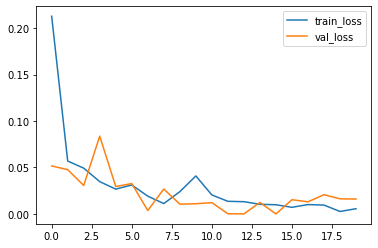

In [25]:
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend()

# Inference

We wish to obtain the average ranks of relevant documents

In [30]:
checkpoint = torch.load("BERT_ABSTRACT.pt") 
model = BERT_ABSTRACT() 
model.load_state_dict(checkpoint)  
model.cuda() 
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

BERT_ABSTRACT(
  (bert1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [49]:
classes = [] 
for i in tqdm(range(len(test_abstract1_input_ids)), position=0, leave=True): 
    ### stores (score, index) ### 
    ids1 = test_abstract1_input_ids[i] 
    ids1 = torch.reshape(ids1, (1, 512)) 
    ids1 = ids1.to(device) 
        
    masks1 = test_abstract1_attention_masks[i] 
    masks1 = torch.reshape(masks1, (1,512)) 
    masks1 = masks1.to(device) 
        
    ids2 = test_abstract2_input_ids[j] 
    ids2 = torch.reshape(ids2, (1,512)) 
    ids2 = ids2.to(device)  
        
    masks2 = test_abstract2_attention_masks[j] 
    masks2 = torch.reshape(masks2, (1,512)) 
    masks2 = masks2.to(device) 
        
    with torch.no_grad(): 
        outputs = model(ids1 = ids1, 
                        masks1 = masks1, 
                        ids2 = ids2, 
                        masks2 = masks2)
        
    score = outputs.detach().cpu().numpy().flatten()[0] 
    classes.append(1 if score > 0.5 else 0) 
    

100%|██████████| 1162/1162 [00:37<00:00, 30.66it/s]


In [50]:
correct = 0 
for i in range(len(test_labels)): 
    ground_truth = test_labels[i].detach().numpy()[0]
    if classes[i] == int(ground_truth): 
        correct += 1 
        
print("accuracy = {}%".format(correct / len(test_labels) * 100))

accuracy = 99.82788296041308%
